In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle

In [3]:
df=pd.read_csv('Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
df.shape

(545, 13)

In [5]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [6]:
df.nunique()

price               219
area                284
bedrooms              6
bathrooms             4
stories               4
mainroad              2
guestroom             2
basement              2
hotwaterheating       2
airconditioning       2
parking               4
prefarea              2
furnishingstatus      3
dtype: int64

In [7]:
numeric_cols=df.select_dtypes(include=np.number).columns.tolist()
categorical_cols=df.select_dtypes(include='object').columns.tolist()
print("numeric_cols=",numeric_cols)
print("categorical_cols=",categorical_cols)


numeric_cols= ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
categorical_cols= ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


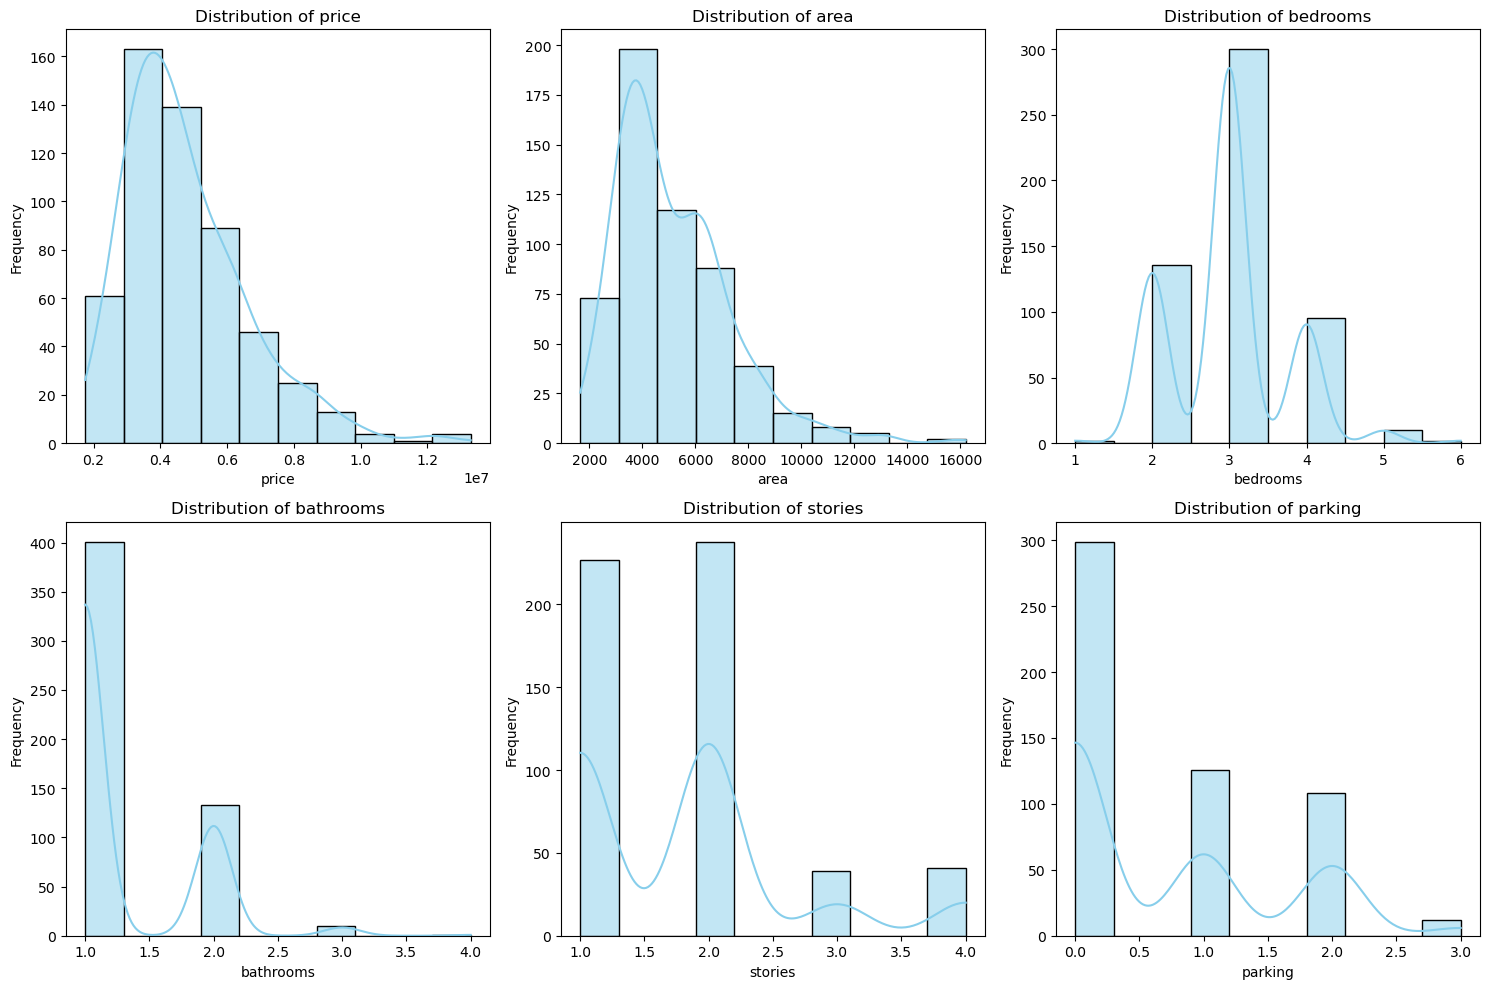

In [8]:
n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols)  # Ceiling division

plt.figure(figsize=(15, 5 * n_rows))

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df[col], bins=10, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
df[numeric_cols].skew()


price        1.212239
area         1.321188
bedrooms     0.495684
bathrooms    1.589264
stories      1.082088
parking      0.842062
dtype: float64

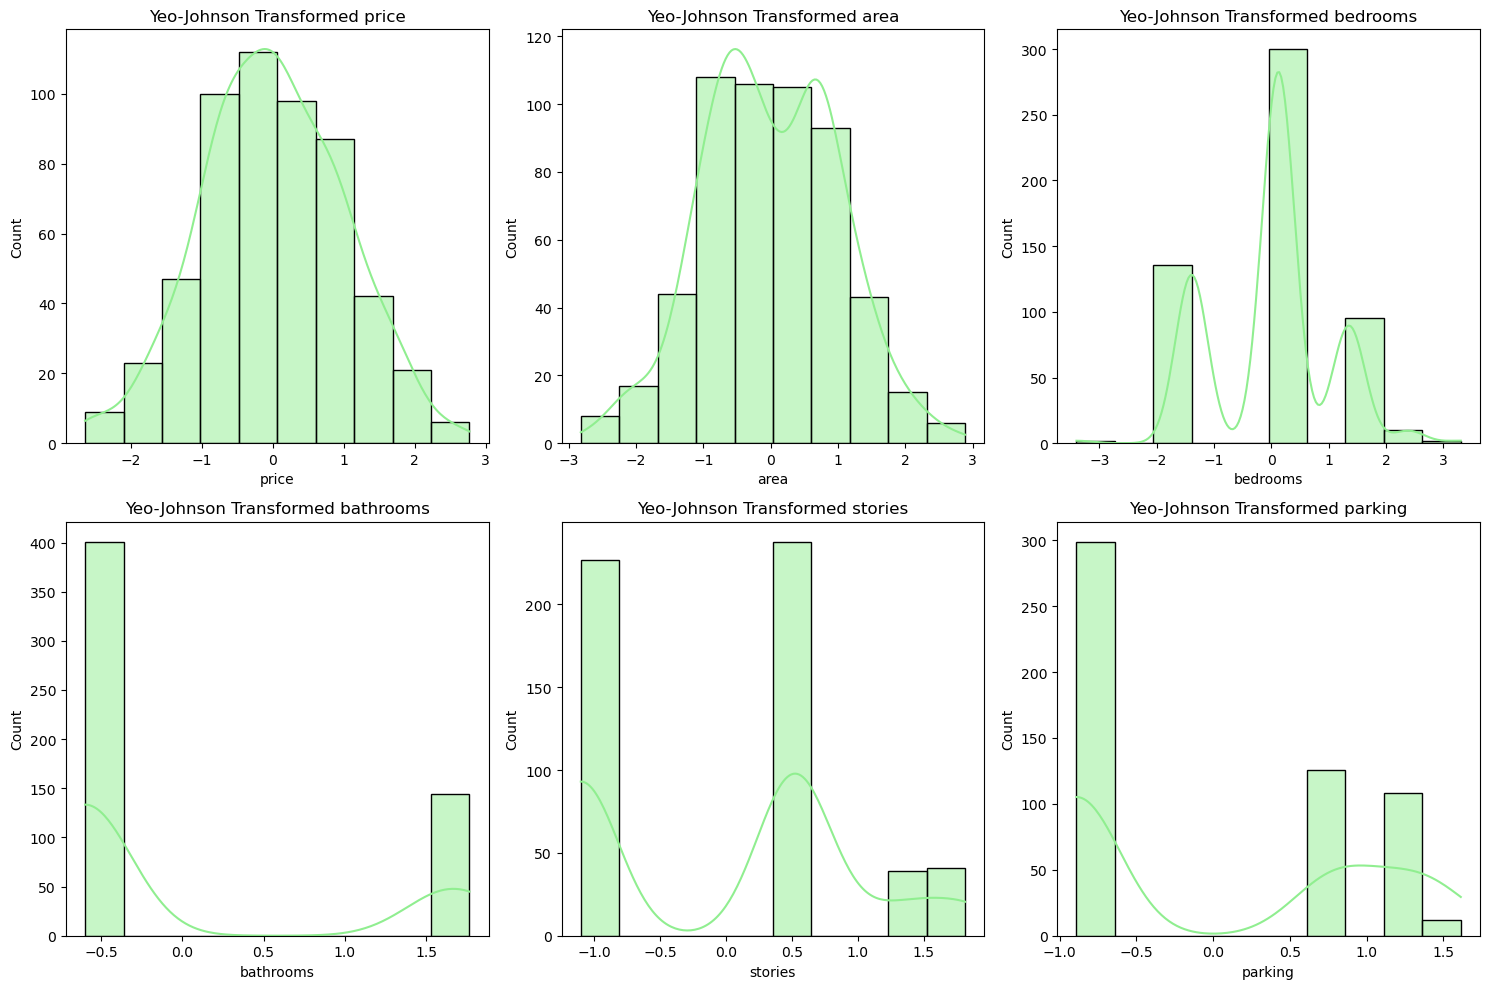


Skewness after Yeo-Johnson transformation:
price        0.002774
area         0.004175
bedrooms     0.000540
bathrooms    1.073066
stories      0.121281
parking      0.311355
dtype: float64


In [10]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
df_transformed = pd.DataFrame(pt.fit_transform(df[numeric_cols]), columns=numeric_cols)

# 4️⃣ Plot transformed distributions
plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df_transformed[col], bins=10, kde=True, color='lightgreen')
    plt.title(f'Yeo-Johnson Transformed {col}')
plt.tight_layout()
plt.show()

# 5️⃣ Skewness after transformation
print("\nSkewness after Yeo-Johnson transformation:")
print(df_transformed.skew())

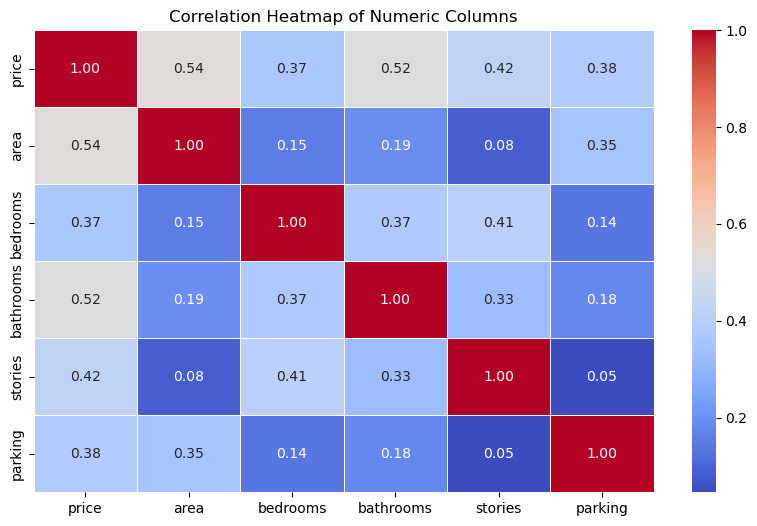

In [11]:
corr = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Columns")
plt.show()

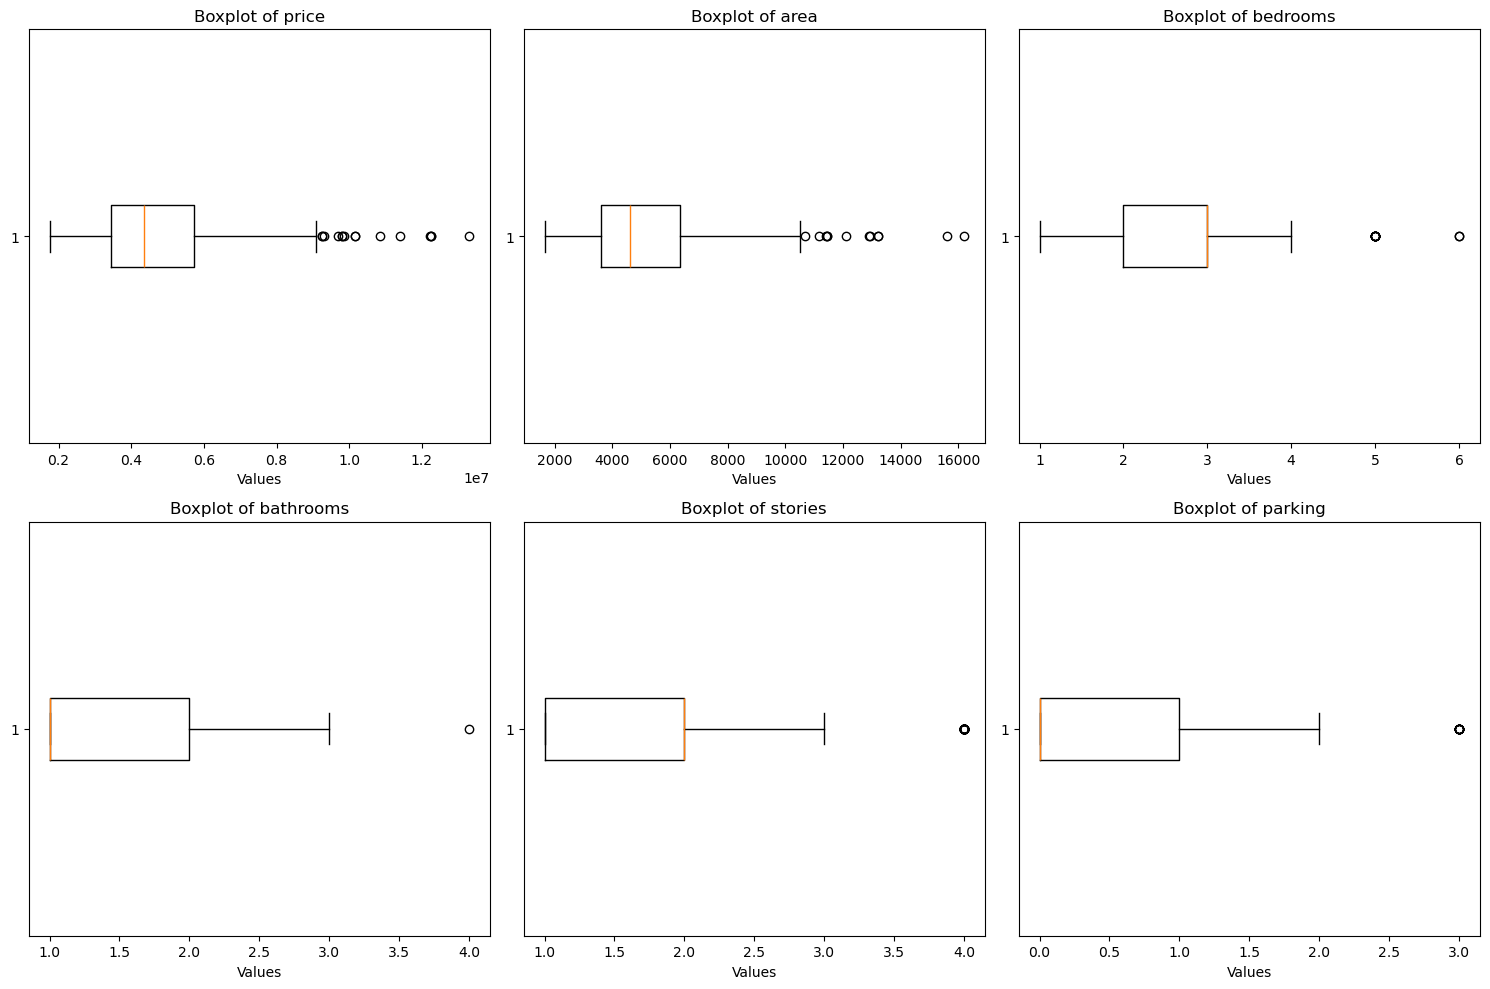

In [12]:
import matplotlib.pyplot as plt

numeric_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

# Create subplots automatically
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows x 3 columns
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    ax.boxplot(df[col], vert=False)
    ax.set_title(f'Boxplot of {col}')
    ax.set_xlabel('Values')

# Hide unused axes (if any)
for ax in axes[len(numeric_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()



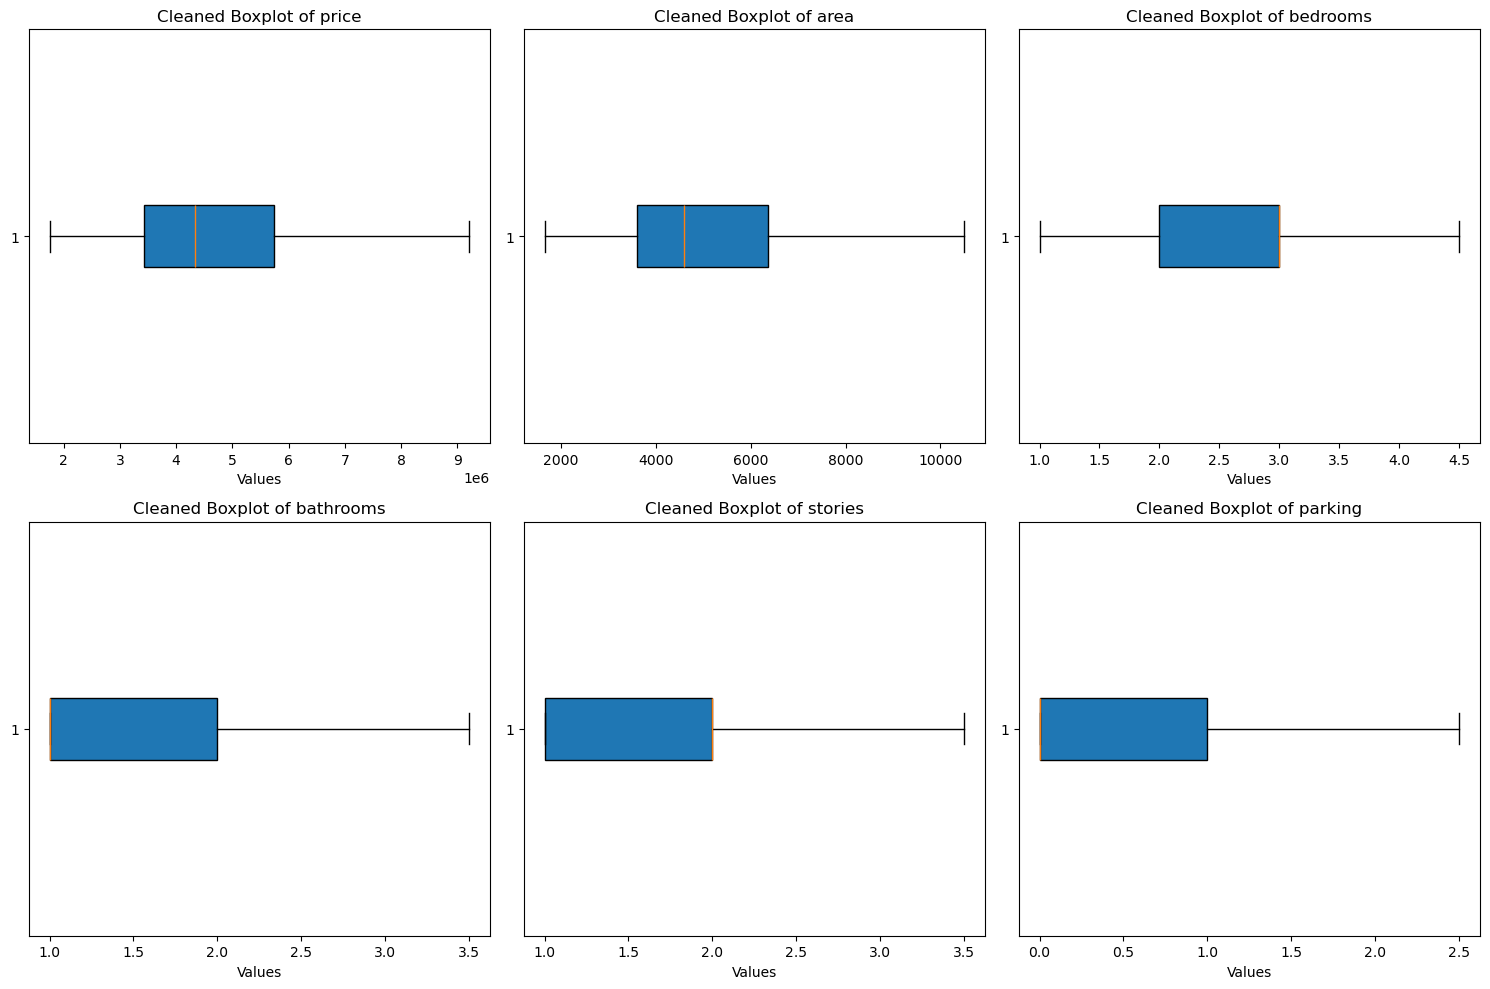

In [13]:
import matplotlib.pyplot as plt

numeric_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

# Step 1: Cap outliers using IQR
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap values
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

# Step 2: Plot cleaned boxplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    ax.boxplot(df[col], vert=False, patch_artist=True, flierprops=dict(marker='o', color='red', markersize=8))
    ax.set_title(f'Cleaned Boxplot of {col}')
    ax.set_xlabel('Values')

for ax in axes[len(numeric_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()



In [14]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pickle

# Categorical columns
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                    'airconditioning', 'prefarea', 'furnishingstatus']

# Encode categorical features
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Feature engineering
df_encoded['area_per_story'] = np.where(df_encoded['stories'] != 0,
                                        df_encoded['area'] / df_encoded['stories'], 0)
df_encoded['bed_bath_ratio'] = np.where(df_encoded['bathrooms'] != 0,
                                        df_encoded['bedrooms'] / df_encoded['bathrooms'], 0)
df_encoded['rooms_per_story'] = np.where(df_encoded['stories'] != 0,
                                         df_encoded['bedrooms'] / df_encoded['stories'], 0)
df_encoded['parking_per_story'] = np.where(df_encoded['stories'] != 0,
                                           df_encoded['parking'] / df_encoded['stories'], 0)

amenities = ['mainroad_yes', 'guestroom_yes', 'basement_yes', 'hotwaterheating_yes',
             'airconditioning_yes', 'prefarea_yes']
df_encoded['amenities_score'] = df_encoded[amenities].sum(axis=1)

# Remove extreme outliers in price
Q1 = df_encoded['price'].quantile(0.25)
Q3 = df_encoded['price'].quantile(0.75)
IQR = Q3 - Q1
df_encoded = df_encoded[(df_encoded['price'] >= Q1 - 1.5*IQR) & 
                        (df_encoded['price'] <= Q3 + 1.5*IQR)].reset_index(drop=True)

# Split features and target
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# Scale numeric columns
numeric_cols = ['area','bedrooms','bathrooms','stories','parking',
                'area_per_story','bed_bath_ratio','rooms_per_story',
                'parking_per_story','amenities_score']
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)


# Train KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # you can tune this value
knn.fit(X_train, y_train)

# 5-fold CV RMSE
cv_rmse = -cross_val_score(knn, X_train, y_train, cv=5,
                           scoring='neg_root_mean_squared_error').mean()
print("5-Fold CV RMSE:", cv_rmse)

# Test evaluation
y_pred = knn.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {test_rmse:,.0f}")
print(f"Test R²: {test_r2:.2f}")

5-Fold CV RMSE: 1001472.2123285048
Test RMSE: 1,338,395
Test R²: 0.56


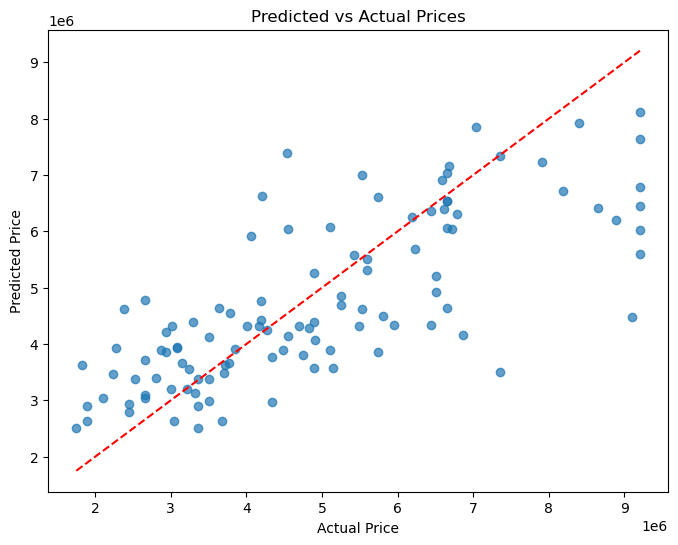

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.show()

In [19]:
scaler.fit(X_train[numeric_cols])
knn.fit(X_train, y_train)

# Save the model, scaler, and feature columns for Streamlit app
with open("model.pkl", "wb") as f:
    pickle.dump(knn, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
feature_columns = X_train.columns.tolist()
with open("feature_columns.pkl", "wb") as f:
    pickle.dump(feature_columns, f)

print("Model and scaler saved!")



Model and scaler saved!
